10.4 RNN 的高级用法

---

前排提醒,本节的模型训练时间很长,几小时那种.

---

到目前为止,我们已经学过的内容

- 什么是 RNN 及它如何工作
- 什么是 ltsm 及 ltsm 比简单 rnn 更好
- 如何使用 keras 的 rnn 层处理时序数据.

接下来我们会学习 keras rnn 的高级特性,这可以帮助我们的模型达到更好的效果.

- 循环 dropout: 在 rnn 层应用 dropout.
- 堆叠循环层: 提高模型的容量和表现力,代价是更高的计算消耗.
- 双向 RNN: 将相同的信息正向/反向送入模型,提高精读缓解遗忘问题.


## 循环 dropout 缓解过拟合

回顾 10.2 节的 ltsm 模型,尽管小模型可以击败基线,但是非常快的过拟合了,原因可能是模型容量过小.

在更前面的内容中对抗过拟合有一个非常有效的办法 -> dropout,但是 dropout 在 rnn 并不是一件容易的事情..

如果直接应用 dropout,那对 rnn 模型可能是一件坏事而不是好事,droupout 总是会破坏学习过程.直到 2015 年,Yarin Gal 在博士论文确定了 rnn 使用 droupout 的正确方式: 对每个时间步使用相同的 dropout 掩码(dropout mask,相同模式的舍弃单元),而不是让 dropout 掩码随着时间变化而随机变化.更重要的是为了对 GRU ltsm 等循环层做正则化表示,应该将不随时间变化的 dropout 掩码应用在层的内部循环激活上(成为 循环 dropout 掩码).对每个时间步长使用相同的 dropout 掩码,可以让我按钮沿着时间正确传播学习误差,而随着时间变化的 dropout 掩码会破坏这个过程.

Yarin Gal 使用 keras 进行的研究,帮助将这种机制直接内置到了 keras 的 rnn 层中.keras 的 rnn 层都有两个与 dropout 相关的参数:

- `dropout`: 浮点数,指定该层每个输入单元 dropout 的比例.
- `recurrent_dropout`: 指定循环单元的 dropout 的比例.

我们先第一个 ltsm 的例子中添加 dropout,看看这样对过拟合的影响.


In [2]:
from tensorflow import keras
import tensorflow.keras.layers as layers

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
sequence_length = 120

import numpy as np
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

temperature = np.zeros((len(lines), ))  #全0 数组
raw_data = np.zeros((len(lines), len(header) - 1))  #全0 数组
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]  #每行的第一个值是时间戳，所以从第二个开始
    temperature[i] = values[1]  #第一个值是温度
    raw_data[i, :] = values[:]  #每行的数据

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples


mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [5]:
sampling_rate = 6  # 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)  #24小时后
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

准备 10.2 的数据


In [5]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25,
                unroll=True)(inputs)  #按照后文提示设置了 unroll=True,训练时间也是完全不能接受
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

---

这里会有一个警告:  Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.

常见
> <https://keras.io/api/layers/recurrent_layers/lstm/>
> <https://stackoverflow.com/questions/62044838/using-cudnn-kernel-for-lstm>

似乎是因为 `recurrent_dropout` 不为 0,所有不能使用 cuDNN 内核.结果是训练非常缓慢.

---


我们在原模型上应用了 gropout 层,设置了 `recurrent_dropout=0.25`.


In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)  #保存最好的模型
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [7]:
history = model.fit(
    train_dataset,
    epochs=50,  # 5 倍的训练
    validation_data=val_dataset,
    callbacks=callbacks)


Epoch 1/50
819/819 [==============================] - 90s 75ms/step - loss: 29.0844 - mae: 3.9676 - val_loss: 9.5179 - val_mae: 2.3942
Epoch 2/50
819/819 [==============================] - 55s 67ms/step - loss: 15.0497 - mae: 3.0137 - val_loss: 9.1772 - val_mae: 2.3529
Epoch 3/50
819/819 [==============================] - 53s 65ms/step - loss: 14.2617 - mae: 2.9347 - val_loss: 8.9910 - val_mae: 2.3270
Epoch 4/50
819/819 [==============================] - 55s 67ms/step - loss: 13.7550 - mae: 2.8793 - val_loss: 9.0376 - val_mae: 2.3267
Epoch 5/50
819/819 [==============================] - 54s 66ms/step - loss: 13.2614 - mae: 2.8311 - val_loss: 8.9118 - val_mae: 2.3105
Epoch 6/50
819/819 [==============================] - 54s 66ms/step - loss: 12.9278 - mae: 2.7922 - val_loss: 8.9167 - val_mae: 2.3117
Epoch 7/50
819/819 [==============================] - 54s 65ms/step - loss: 12.6572 - mae: 2.7651 - val_loss: 8.8193 - val_mae: 2.2974
Epoch 8/50
819/819 [==============================] - 5

因为更不容易过拟合,设置训练轮次是 5 倍之前, 50 次.(慢的要死)

在 cpu 上跑反而更快的多...


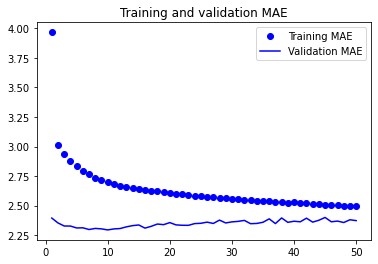

In [8]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [9]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 7s 18ms/step - loss: 10.6795 - mae: 2.5664
Test MAE: 2.57


过拟合被有效缓解了,训练超过 20 轮以后也没有明显过拟合.

验证集的 mae 在 2.27 2.28,测试集的 mae 在 2.57 与基线差别不大,但也不坏.


### 小贴士

keras ltsm/gru 训练时 gpu 上使用 cuDNN 内核的前提是保持默认参数,上文我们打破了,所以无法调用 cuDNN 内核.模型的训练时间也就回退到了普通 tensorflow 的思想,比通常慢 3~5 倍

当我们不能使用 cuDNN 时,可以尝试解卷积,解除 for 循环,并简单将其转换为内联(??),看原文就是增加一个参数 `unroll=True`,不过这样会大大增加显存的消耗,而且不能向模型传递任何没有固定形状的数据.(就是不能有 None).

In [10]:
# inputs = keras.Input(shape=(sequence_length, num_features))
# x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

## rnn 堆叠

模型不再过拟合吗,但是似乎遇到了性能瓶颈.此时需要考虑增大网络容量了.

回顾一下机器学习的基本流程: 增加网络容量通常是个好办法,直到过拟合变为主要障碍(假设已经采取了基本的降低过拟合的策略,例如 dropout),只要不是过拟合太严重,很可能是容量不足问题.

增加网络容量的办法通常是增加每层的单元数,或者增加层数,rnn 堆叠是更加更强大 rnn 网络的经典方法,目前 google 的翻译算法就是 7 个大型 ltsm 的堆叠.

为了将 rnn 层堆叠起来,所有中间层都需要输出网站的序列,而不是只输出最后一个时间步的输出.这是通过指定 `return_sequences=True` 实现的.

下面的例子中我们会将 ltsm 范围 gru,gru 和 ltsm 非常相似,你可以将其视为 ltsm 的简化版本.


In [6]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, unroll=True,
               return_sequences=True)(inputs)  #unroll 加速
x = layers.GRU(32, recurrent_dropout=0.5, unroll=True)(x)  #unroll 加速
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

这里我们还是不能使用 cuRNN 内核,所以训练非常之慢...换用 cpu 快多了.

---

我们堆叠了两个 gru 层,同时使用了 dropout.


In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 258s 226ms/step - loss: 26.3653 - mae: 3.7821 - val_loss: 9.3842 - val_mae: 2.3684
Epoch 2/50
819/819 [==============================] - 228s 278ms/step - loss: 14.2408 - mae: 2.9265 - val_loss: 8.8731 - val_mae: 2.3025
Epoch 3/50
819/819 [==============================] - 231s 282ms/step - loss: 13.4200 - mae: 2.8419 - val_loss: 8.9448 - val_mae: 2.3159
Epoch 4/50
819/819 [==============================] - 230s 281ms/step - loss: 12.9980 - mae: 2.7954 - val_loss: 8.9620 - val_mae: 2.3262
Epoch 5/50
819/819 [==============================] - 231s 283ms/step - loss: 12.5208 - mae: 2.7459 - val_loss: 9.2913 - val_mae: 2.3708
Epoch 6/50
819/819 [==============================] - 227s 278ms/step - loss: 12.1317 - mae: 2.7011 - val_loss: 8.6307 - val_mae: 2.2759
Epoch 7/50
819/819 [==============================] - 229s 279ms/step - loss: 11.8624 - mae: 2.6694 - val_loss: 8.5517 - val_mae: 2.2660
Epoch 8/50
819/819 [=====================

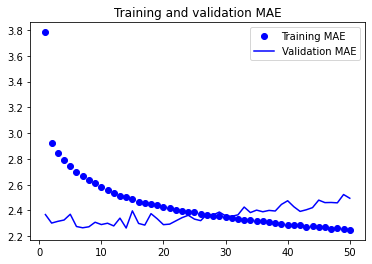

In [9]:
import matplotlib.pyplot as plt 
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [10]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 37s 64ms/step - loss: 9.4611 - mae: 2.4111
Test MAE: 2.41


验证集上 mae 最低能到 2.27 的样子,测试集上 mae 是 2.41.比前面的结果好,但是有限.


## 双向 rnn

本节介绍的最后一种方法叫做双向 rnn,双向 rnn 是一种常见的 rnn 变体,它在某些任务上表现比普通 rnn 更好,常用于自然语言处理.

rnn 非常依赖与输入顺序/时间.rnn 按照顺序处理序列的时间步,而打乱时间步或者反转时间步将会完全改变 rnn 从序列中提取的模式.正是这个原因使得 rnn 在顺序敏感问题上表现很好.双向 rnn 利用了 rnn 对顺序的敏感性: 它包含两个普通 rnn,每个 rnn 分别沿着输入序列的正序和逆序进行处理,最后将结果合并.双向 rnn 有可能捕获单向 rnn 忽略的模式.


值得注意的是截止到现在,本文例子中的 rnn 模型输入全部都是正向,至少我们没有刻意尝试逆向.逆向序列会更好吗?我们尝试一下第一个实验中使用的 ltsm 模型.(将输入实例程序替换 yield  samples[:, ::-1, :], targets)

![backwards_lstm_model_metrics](backwards_lstm_model_metrics.png)

逆序 ltsm 的结果,甚至低于基线..这表明至少在这个实验中,按照时间正向输入数据对解决问题非常重要: ltsm 在记忆刚刚过去的时间比记忆更遥远过去更加容易,对这个问题而言,较劲的天气数据比较早的数据预测上更有价值,因此输入正向的序列结果肯定比逆序的要好.
